# Import dependencies

In [3]:
import math
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# Load dataset

In [67]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [68]:
X = train_data.drop('label', axis=1)
y = train_data['label']

X.shape, y.shape

((42000, 784), (42000,))

In [69]:
X_test = test_data

X_test.shape

(28000, 784)

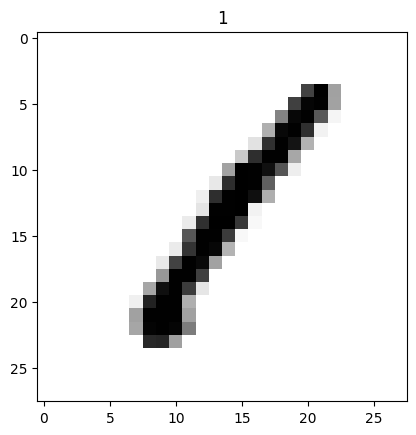

In [70]:
index = 0
plt.title((y.iloc[index]))
plt.imshow(X.iloc[index].values.reshape(28,28), cmap=cm.binary)
plt.show()

In [71]:
X = X.values.reshape((784, 42000))
y = pd.get_dummies(y).values.reshape(10, 42000)

X_test = X_test.values.reshape((784, -1))
            
X.shape, y.shape, X_test.shape

((784, 42000), (10, 42000), (784, 28000))

# Define functions

In [4]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)    
    cache = Z 
    return A, cache

def softmax(Z):
    e_x = np.exp(Z)
    A= e_x / np.sum(np.exp(Z))  
    cache=Z
    return A,cache  

In [5]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

def softmax_backward(Z,cache):
    Z=cache
    length=10  
    dZ=np.zeros((42000,10))
    Z=np.transpose(Z)
    for row in range (0,42000):
            den=(np.sum(np.exp(Z[row,:])))*(np.sum(np.exp(Z[row,:])))
            for col in range (0,10):
                sums=0
                for j in range (0,10):
                    if (j!=col):
                        sums=sums+(math.exp(Z[row,j]))
                
                dZ[row,col]=(math.exp(Z[row,col])*sums)/den           
    dZ=np.transpose(dZ)
    Z=np.transpose(Z)

    assert (dZ.shape == Z.shape)
    return dZ

In [6]:
def initialize_parameters_deep(layer_dims):
    #np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

In [7]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) +b
    cache = (A, W, b)
    assert(Z.shape == (W.shape[0], A.shape[1]))
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        #print("Z="+str(Z))
        A, activation_cache = relu(Z) 
    elif activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)               
    return AL, caches

In [34]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    #print("cost="+str(cost))
    return cost

In [35]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)  
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True);
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    M=len(layers_dims)
    current_cache = caches[M-2]
    grads["dA"+str(M-1)], grads["dW"+str(M-1)], grads["db"+str(M-1)] = linear_activation_backward(dAL, current_cache, activation = "softmax")#M-1
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [36]:
def update_parameters(parameters, grads, learning_rate):
    for l in range(len_update-1):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)] - (learning_rate*grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate*grads["db" + str(l+1)])
    return parameters

In [38]:
def L_layer_model(X, Y, layers_dims, learning_rate , num_iterations , print_cost=False):#lr was 0.009
    print("training...")
    costs = []  
    cost_plot=np.zeros(num_iterations)
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost =compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate) 
        cost_plot[i]=cost;
    
    plot_graph(cost_plot)
    return parameters

In [39]:
def plot_graph(cost_plot):
    x_value=list(range(1,len(cost_plot)+1))
    #print(x_value)
    #print(cost_plot)
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.plot(x_value,cost_plot,0.,color='g')

# Train

training...
training done


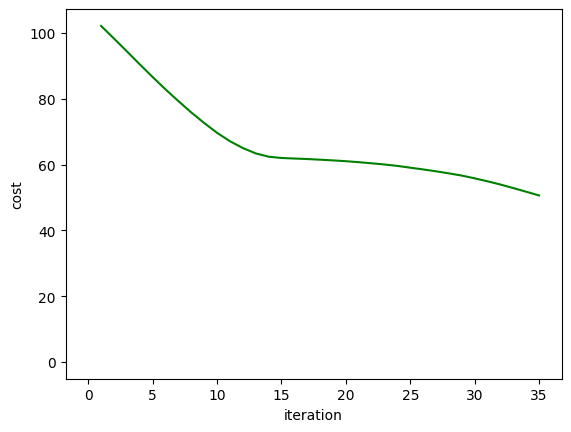

In [99]:
#defining structure of neural network
layers_dims = [784, 500, 400, 300, 100, 10] #  n-layer model (n=6 including input and output layer)
len_update = len(layers_dims)
parameters = L_layer_model(X, y, layers_dims, learning_rate=0.0005, num_iterations=35, print_cost=True) 
print("training done")

# Infer

In [ ]:
result, _ = L_model_forward(X_test, parameters)

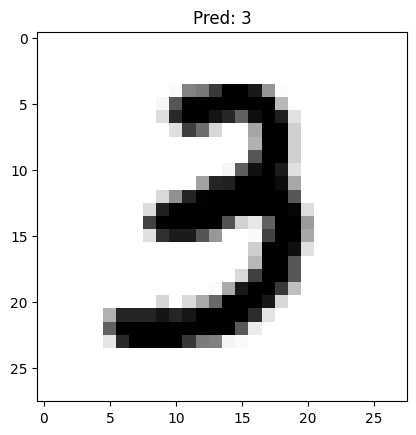

In [117]:
index = 7
plt.title(f'Pred: {np.argmax(result[:, index])}')
plt.imshow(test_data.values[index].reshape(28, 28), cmap=cm.binary)
plt.show()

# Save parameters

In [111]:
with open('checkpoint/parameters.pkl', 'wb') as f:
    pickle.dump(parameters, f)

# Load parameters

In [9]:
with open('checkpoint/parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [43]:
from PIL import Image

img = Image.open('input.jpg')
img = np.array(img).reshape(784, 1)

In [44]:
result, _ = L_model_forward(img, parameters)

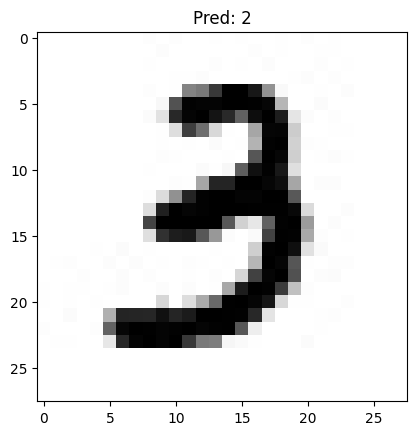

In [45]:
plt.title(f'Pred: {np.argmax(result)}')
plt.imshow(img.reshape(28, 28), cmap=cm.binary)
plt.show()

In [46]:
exit(0)

: 